# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad, vmap
import qcsys as qs
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 2 - Devices

In [3]:
_, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(4.134, 50)

resonator = qs.Resonator.create(
    10,
    {"Ec": Ec_a, "El": El_a},
    N_pre_diag=10,
)

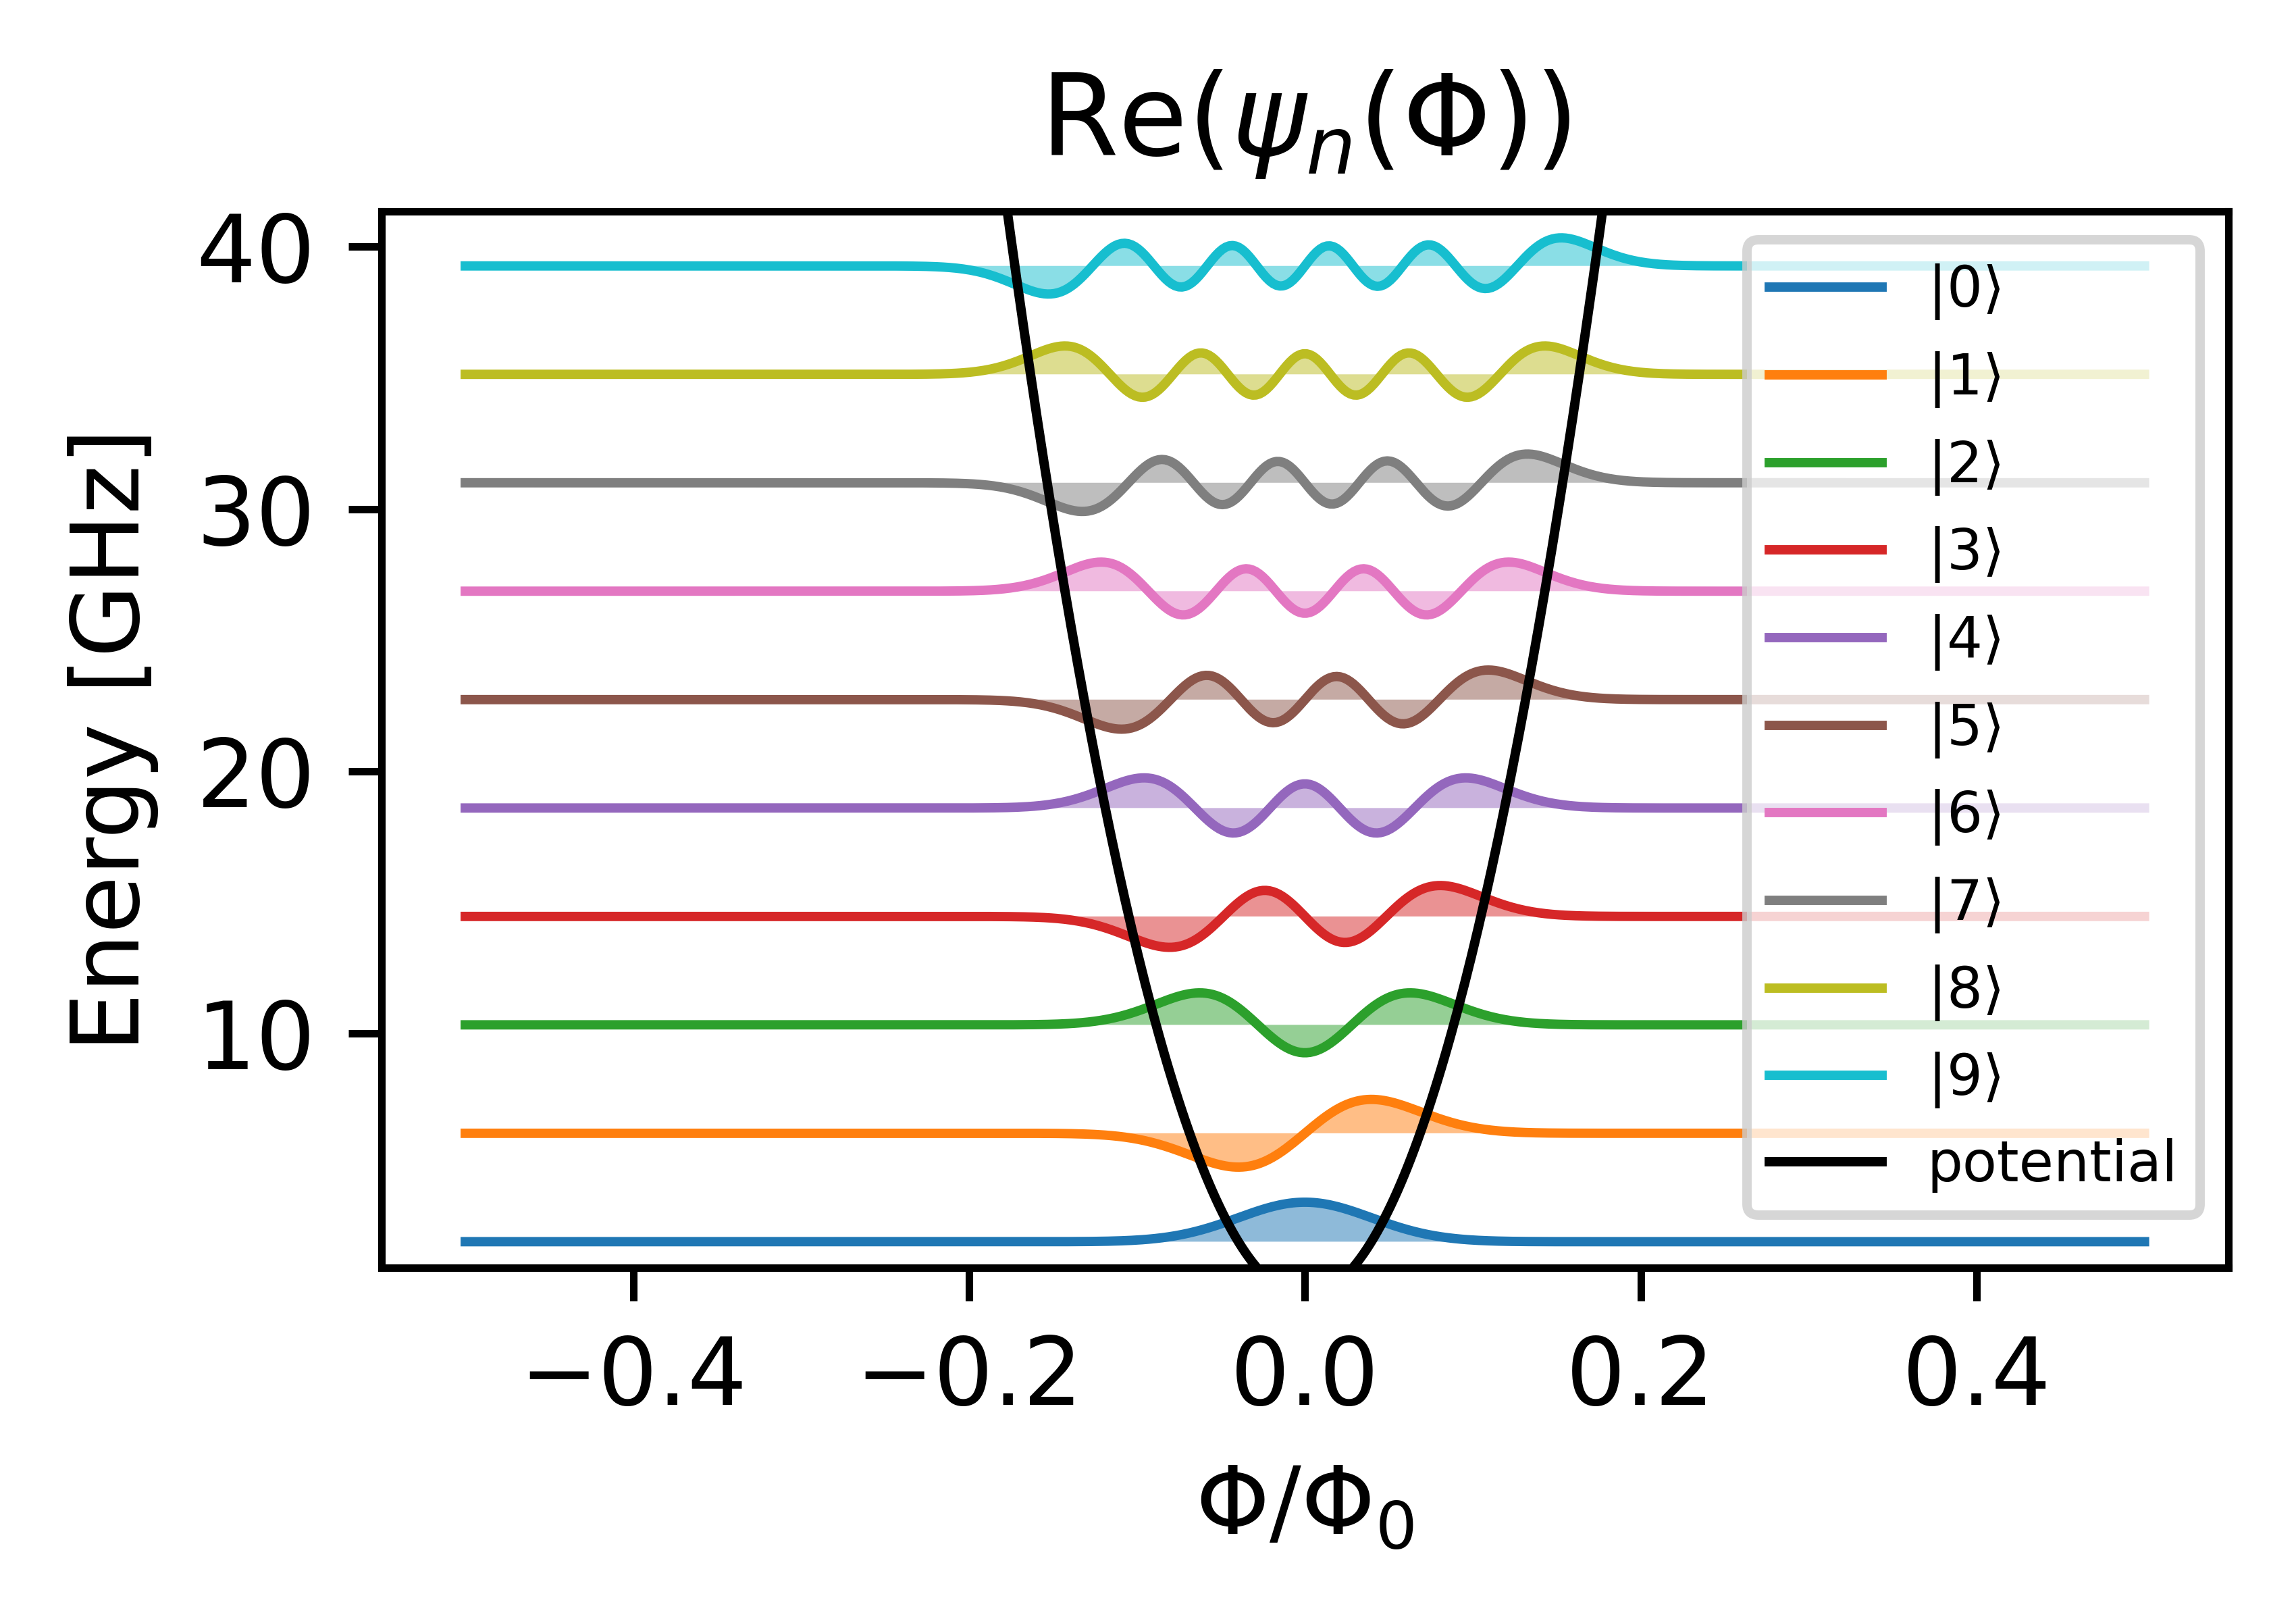

In [4]:
phi_vals = jnp.linspace(-0.5,0.5,500)
axs = resonator.plot_wavefunctions(phi_vals, mode="real")

In [5]:
Ec_q = 0.844
El_q = 0.3
Ej_q = 3.755

qubit = qs.Fluxonium.create(
    25,
    {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": 0.47},
    use_linear=False,
    N_pre_diag=100,
)

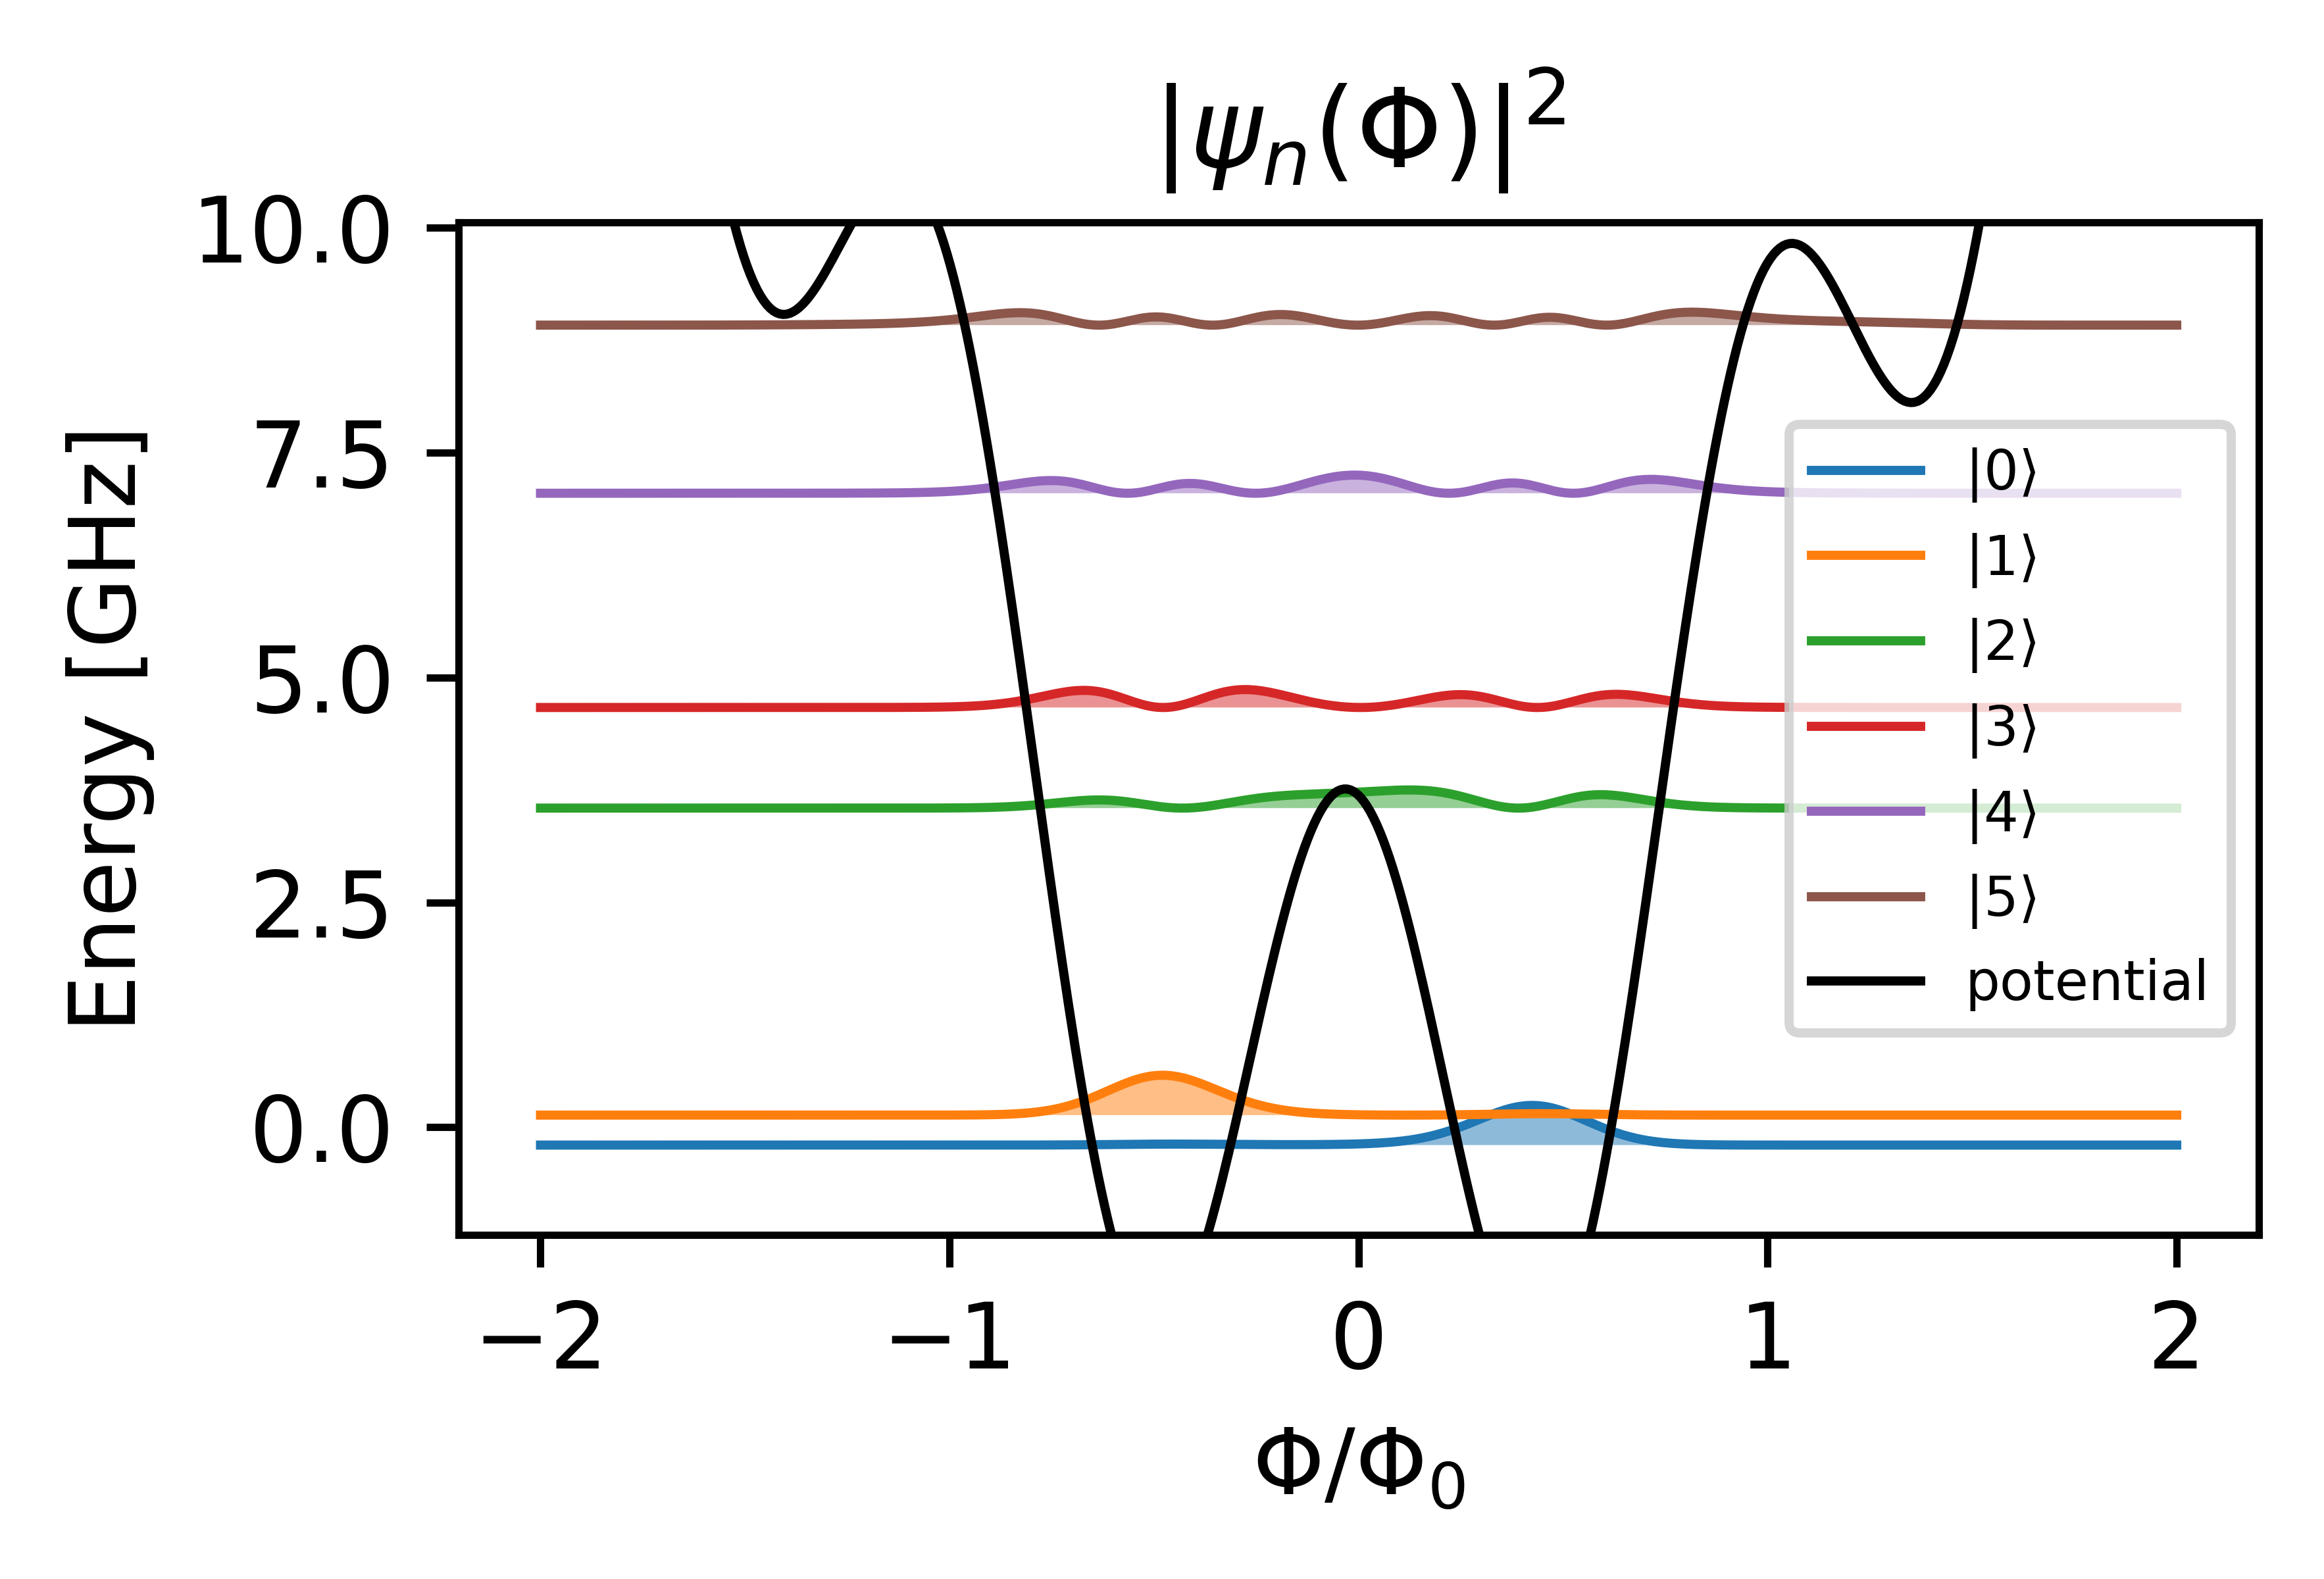

In [6]:
phi_vals = jnp.linspace(-2,2,500)
axs = qubit.plot_wavefunctions(phi_vals, max_n=6)

# 3 - System

In [ ]:
g_rq = 0.3

devices = [resonator, qubit]
r_indx = 0
q_indx = 1
Ns = [device.N for device in devices]

a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

couplings = []
couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

system = qs.System.create(devices, couplings=couplings)
system.params["g_rq"] = g_rq

In [37]:
Es, kets = system.calculate_eig()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([ 0.03456383,  0.17578938,  0.10231437,  0.0539388 , -0.87271408,
         0.        ,  0.81095429, -0.81095429,  0.34985242], dtype=float64),
 Array([-0.03528075,  0.06014532,  0.03404121,  0.02017985,  0.01159352,
         0.01144715, -1.57487895,  1.85171634], dtype=float64),
 Array([ 0.1059448 , -0.01332969, -0.01433436, -0.90647303,  0.8843076 ,
         0.82240144, -3.19678753,  3.01252305], dtype=float64))

In [38]:
Es, kets = system.calculate_eig()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([ 0.03456383,  0.17578938,  0.10231437,  0.0539388 , -0.87271408,
         0.        ,  0.81095429, -0.81095429,  0.34985242], dtype=float64),
 Array([-0.03528075,  0.06014532,  0.03404121,  0.02017985,  0.01159352,
         0.01144715, -1.57487895,  1.85171634], dtype=float64),
 Array([ 0.1059448 , -0.01332969, -0.01433436, -0.90647303,  0.8843076 ,
         0.82240144, -3.19678753,  3.01252305], dtype=float64))

# 4 - Sweep

In [44]:
def calculate_metrics(phi_ext):
    # devices ---

    # Resonator
    _, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(4.134, 50)

    resonator = qs.Resonator.create(
        10,
        {"Ec": Ec_a, "El": El_a},
        N_pre_diag=10,
    )

    # Fluxonium
    Ec_q = 0.844
    El_q = 0.3
    Ej_q = 3.755

    qubit = qs.Fluxonium.create(
        25,
        {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": phi_ext},
        use_linear=False,
        N_pre_diag=100,
    )

    # system ----
    J_rq = 3e-3
    g_rq = J_rq * qubit.n_zpf() * resonator.n_zpf()

    devices = [resonator, qubit]
    r_indx = 0
    q_indx = 1
    Ns = [device.N for device in devices]

    a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
    a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

    q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
    q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

    couplings = []
    couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

    system = qs.System.create(devices, couplings=couplings)
    system.params["g_rq"] = g_rq

    # metrics ----
    Es, kets = system.calculate_eig()

    # chi
    χ_e = Es[1:, 1] - Es[:-1, 1]
    χ_g = Es[1:, 0] - Es[:-1, 0]
    χ = χ_e - χ_g

    # kerr
    # kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
    # kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
    K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
    K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

    χ, K_g, K_e

    return {
        "χ": χ[0],
        "K_g": K_g[0],
        "K_e": K_e[0],
        "f_r": Es[1,0] - Es[0, 0],
        "f_q": Es[0,1] - Es[0, 0],
    }

calculate_metrics_map = jit(vmap(calculate_metrics))

In [45]:
phi_exts = jnp.linspace(0.4, 0.51, 101)
metrics = calculate_metrics_map(phi_exts)

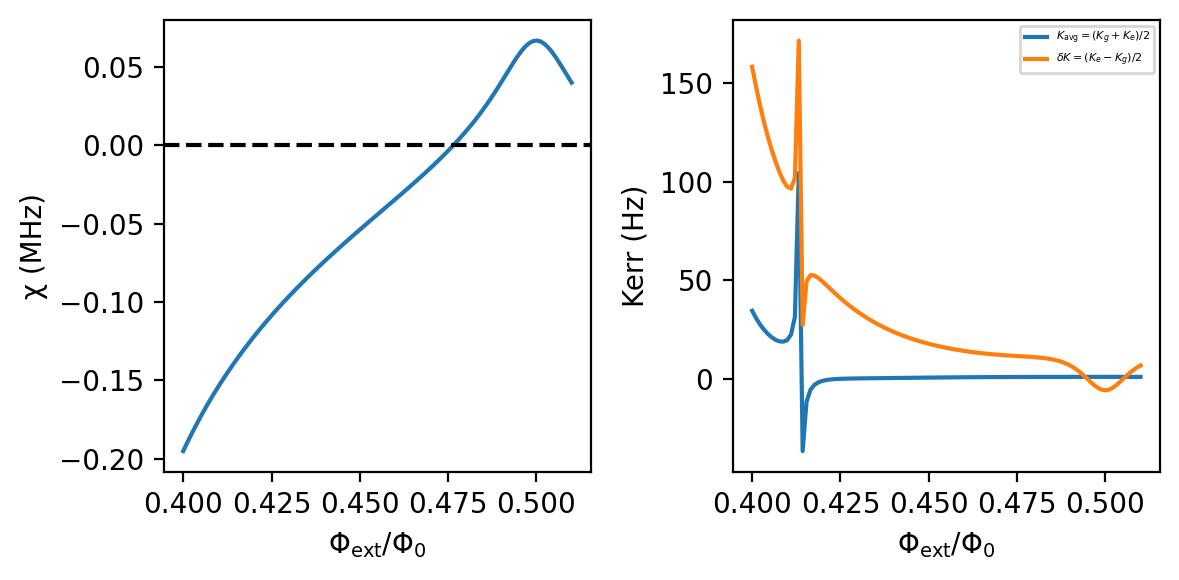

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax = axs[0]
ax.plot(phi_exts, 1e3*metrics["χ"])
ax.axhline(0, color="black", linestyle="--")
ax.set_xlabel(r"$\Phi_{\rm ext}/\Phi_0$")
ax.set_ylabel("χ (MHz)")

ax = axs[1]
ax.plot(phi_exts, 1e9*(metrics["K_g"] + metrics["K_e"])/2, label=r"$K_{\rm avg} = (K_g + K_e)/2$")
ax.plot(phi_exts, 1e9*(metrics["K_e"] - metrics["K_g"])/2, label=r"$\delta K = (K_e - K_g)/2$")
ax.set_xlabel(r"$\Phi_{\rm ext}/\Phi_0$")
ax.set_ylabel("Kerr (Hz)")
ax.legend(fontsize=4)

fig.tight_layout()

# 4 - auto differentiation

In [51]:
calculate_metrics_grad = jit(grad(lambda phi_ext: calculate_metrics(phi_ext)["f_r"]))

In [52]:
calculate_metrics_grad(0.5) # This should be near 0 as this is a first-order flux insensitive sweet spot for the fluxonium. 

Array(3.40207775e-20, dtype=float64, weak_type=True)

In [64]:
flux_noise_amplitude = 5e-6 # 10 uPhi_0
Gamma_phi_resonator = jnp.abs(calculate_metrics_grad(0.47) * flux_noise_amplitude)
T_phi_resonator = 1/(2*jnp.pi*Gamma_phi_resonator) * 1e-6 # in milliseconds
print("T_phi,a = ", T_phi_resonator, "ms")

T_phi,a =  29.324736183011545 ms
